In [1]:
pip install pdfplumber==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 7.9 MB/s eta 0:00:00


In [2]:
pip install gensim

In [3]:
import pdfplumber
import pandas as pd
import numpy as np
import re
import nltk
from nltk import pos_tag, ne_chunk, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import gensim
import random
pd.set_option('display.max_rows', None)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 1. Data Cleaning: [10 points]
  a. Convert PDFs to text, and extract the title and abstract from each document.  
  b. Programmatically preprocess the texts, which involves removing stop words, removing special or unusual characters, lowercasing, lemmatization, etc.  
  ** You may have to do some manual preprocessing

====== Notes ======

### a. Extract the titles
Keywords may be useful to extract titles:
* Previous: "Research Article", " ", pure numbers, "ICCF", "." (There may also be nothing before the title)
* After: Author names (may contain ". , ( )"), pure numbers
* Titles may be all in "capital letters"

In [5]:
preName = "doc"
postName = ".pdf"
# First extract everything before the abstract
pre_dict = {}
abstract_pattern = re.compile(r'\bAbstract\b', re.IGNORECASE)

for i in range(1, 33):
    doc = preName + str(i) + postName
    pdf = pdfplumber.open(doc)
    page1 = pdf.pages[0].extract_text(x_tolerance=True, y_tolerance=True)
    sentenceList = page1.split('\n')
    # Extract everything before the abstract
    for j in range(len(sentenceList)):
        if abstract_pattern.search(sentenceList[j]):
            pre_dict[i] = []
            for s in range(0, j):
                pre_dict[i].append(sentenceList[s])

In [6]:
# Extract the titles from everything before the abstract (from pre_dict)
pattern1 = r'\b[A-Z]\.\s?|\b\w+\.$|^\d+(\s+\d+)*$'  # Filter out author name and other unwanted patterns (ex: pure numbers "1" "1 2 3 4 5")
pattern2 = r'^\d+\s*$'  # Filter out some pure numbers (ex: "9 ")
raw_title_dict = {}

for idx, value in pre_dict.items():
    for sentence in value:
        if (',' not in sentence) and ('*' not in sentence) and ('∗' not in sentence) and ('(' not in sentence) and (')' not in sentence) and (not re.search(pattern2, sentence)) and (not re.search(pattern1, sentence)) and (sentence != ' ') and ('(' not in sentence) and ('†' not in sentence) and ('©' not in sentence) and ('@' not in sentence) and  ('E-mail' not in sentence) and ('ICCF' not in sentence):
            if idx not in raw_title_dict:
                raw_title_dict[idx] = [sentence]
            else:
                raw_title_dict[idx].append(sentence)


# Remove the word "Research Article" if there's one and concat the titles
title_dict = {}
for idx, value in raw_title_dict.items():
    if "Research Article" in value:
        value.remove("Research Article")

# Manual part: Some author/ institute names and characters is hard to be filter out: List them in a list to filter
filterList = ['Felix Scholkmann', 'FSUE “LUCH”', 'Institute of Physical Chemistry', 'Institute of Physical Chemistry. ', 'Fifth International Conference on Cold Fusion ', 'Hideaki YOSHIT AKE and Nobuyuki KAMIYA ', 'Danie,l S Szumski'
              'Department of Energy Engineering ', 'Yokohama National University ', 'Fifth International Conference on Cold Fusion ', 'Edmund Storms', 'x', 'Saunin and Michael Melich', 'Jean-Paul Biberian', 'Mathieu Valat', 'Institute of Physical Chemistry. ',
              'Martin Fleischmann Memorial Project', 'Walter Sigaut', 'Pierre Clauzon and Jean-François Fauvarque', 'th', 'a', 'a  a', 'a a a a', 'ITALY', 'Raj Ganesh Pala', 'Felix Scholkmann', 'Alla Kornilova and Sergey Gaydamaka', 'Vladimir Vysotskii']

# Filter out all the tokens in the filter list and join the sentences
for idx, value in raw_title_dict.items():
    for sentence in value:
        if sentence in filterList:
            value.remove(sentence)
    raw_title_dict[idx] = " ".join(value).lower().strip()

# Change the titles of the documents to dataframe (doc5, doc6)
title_df = pd.DataFrame(list(raw_title_dict.items()), columns=['document', 'title'])
raw_title_dict

{1: 'heat production and rf detection during cathodic polarization of palladium in 0.1 m liod',
 2: 'electromagnetic emission in the khz to ghz range associated with heat production during electrochemical loading of deuterium into palladium: a summary and analysis of results obtained by different research groups',
 3: 'excess heat production in pd/d during periodic pulse discharge current in various conditions',
 4: 'materials issues of loading deuterium into palladium and  the association with excess heat production',
 5: 'excess heat production and nuclear ash in pdo/pd/pdo heterostructure  after electrochemical saturation with deuterium  the russian academy of sciences. moscow 117915 russia',
 6: 'effect  of  boron  for  the  heat  production  at  the  heavy  water  electrolysis  using  palladium  cathode  department of energy engineering',
 7: 'heat  production  and  trial  to  detect  nuclear  products  from  palladium-deuterium  electrolysis  cells',
 8: 'some characteristics of 

### a. Extract the abstracts

In [32]:
preName = "doc"
postName = ".pdf"
abstract_dict = {}

for i in range(1, 33):
    start = 0
    end = 0
    doc = preName + str(i) + postName
    pdf = pdfplumber.open(doc)
    page1 = pdf.pages[0].extract_text(x_tolerance=True, y_tolerance=True)
    sentenceList = page1.split('\n')

    for j in range(len(sentenceList)):
      if ("abstract" in sentenceList[j].strip().lower() ):
        start = j+1
        end = j+2

        while(end<len(sentenceList) and "introduction" not in sentenceList[end].strip().lower()):
          end +=1
        if end == len(sentenceList):
          end-=1
        break
    temp = []
    for l in range(start,end):
      temp.append(sentenceList[l])

    abstract_dict[i] = str(" ".join(temp))

abstract_dict[1]

'The study of the Fleischmann–Pons Effect (FPE), i.e. the production of excess power production during electrochemical loading of deuterium in palladium (in the past labeled cold fusion) has had a notably multidisciplinary character, involving solid state and nuclear physics, material science, electrochemistry and other ﬁelds. Correlations between the material status and the occurrence of the effect as well as some changes in the electrochemical interface status have been observed. Although during the last two decades, in several calorimetric experiments the effect was observed to be well above the measurement uncertainty, the mechanism producing the excess power is not completely understood. So far, the lack of reproducibility has been responsible for the absence of a clear explanation of the phenomenon based on experimental apparatus designed to enhance the spectrum of information required to deﬁne the effect. Recently, In order to improve this aspect of this research, speciﬁc work h

### b. Programmatically preprocess the texts, which involves removing stop words, removing special or unusual characters, lowercasing, lemmatization, etc.  

In [8]:
# First extract all the content (except for title and abstract) and merge them into a singe string, stored in content_dict
content_dict = {}

# Remove contents before "Introduction" in page 1 (No matter which page it's in)
def removeAbstract(pageSentenceList, doc):
    for i in range(len(pageSentenceList)):
        if ("introduction" in pageSentenceList[i].lower()) or ("_lntrnd_uction_" in pageSentenceList[i].lower()) or ("wkb approximation" in pageSentenceList[i].lower()):  # for doc6 & doc29...
            content_dict[doc] = []
            for j in range(i, len(pageSentenceList)):
                # print(page1SentenceList[j])
                content_dict[doc].append(pageSentenceList[j])
            content_dict[doc] = " ".join(content_dict[doc]).lower().strip()
            break

# Extract contents of first page to the content_dict
for i in range(1, 33):
    doc = preName + str(i) + postName
    pdf = pdfplumber.open(doc)
    pageNum = len(pdf.pages)
    for j in range(pageNum):
        currPage = pdf.pages[j].extract_text(x_tolerance=True, y_tolerance=True).split('\n')
        # Extract the content (filter out titles and abstracts)
        if i not in content_dict:
            removeAbstract(currPage, i)
        else:
            content_dict[i] += " ".join(currPage).lower()  # Turn to lowercases done here!

# content_dict

In [9]:
print(content_dict[1])

1. introduction the excess power effect was observed using both pd and pd90rh10 cathodes [1]. some speciﬁc features were iden- tiﬁed for the active electrodes with both materials [2–4]. the active pd electrodes had mostly (100) orientation of the poly-crystals, enhanced hydrogen (deuterium) diffusivity, average grain size around 100 µm and a well-deﬁned surface morphology identiﬁed by means of the power spectral density function (psd). active pd90rh10 cathodes have a high diffusivity and a surface morphology, in terms of psd [4], very similar to the one belonging to the active pd samples. the differences are a mixed orientation of the crystals and a lower corresponding author. e-mail: vittorio.violante@enea.it ∗ c 2016 iscmns. all rights reserved. issn 2227-3123 !320 v. violante et al. / journal of condensed matter nuclear science 19 (2016) 319–324 figure 1. current ripple during excess power at low data acquisition rate. grain size, typically some tens’ of microns. doping with contami

In [10]:
# Remove stop words, remove special or unusual characters, lowercasing (Done above), lemmatization, etc. from content_dict
def remove_stopWords_weirdChar(sentence):
    # Remove unusual characters that are not letters/ numbers
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    token_words = word_tokenize(sentence)
    # Remove stop words from the document
    stop_words = set(stopwords.words('english'))
    filteredSentence = [token for token in token_words if not token.lower() in stop_words]
    return filteredSentence

# lemmatization
def lemmatization(tokenList):
    lemmatizer = WordNetLemmatizer()
    lem_tokenList = [lemmatizer.lemmatize(token) for token in tokenList]
    return lem_tokenList

# Remove numbers
def remove_numbers(tokenList):
    for tok in tokenList:
        if tok.isdigit():
            tokenList.remove(tok)
    return tokenList

# Remove stop words from all documents, stored in token_dict
token_dict = {}
for idx, sentence in content_dict.items():
    token_dict[idx] = remove_stopWords_weirdChar(sentence)
print("After removing stop words and unusual characters: ")
print(token_dict[1])
print(token_dict[2])

# Lemmatization and remove numbers, stored in cleanToken_dict
cleanToken_dict = {}
for idx, tokenList in token_dict.items():
    # Remove numbers
    tokenList = remove_numbers(tokenList)
    cleanToken_dict[idx] = lemmatization(tokenList)
print("After lemmatization: ")
print(cleanToken_dict[1])
print(cleanToken_dict[2])

After removing stop words and unusual characters: 
['1', 'introduction', 'excess', 'power', 'effect', 'observed', 'using', 'pd', 'pd90rh10', 'cathodes', '1', 'speci', 'c', 'features', 'iden', 'ti', 'ed', 'active', 'electrodes', 'materials', '2', '4', 'active', 'pd', 'electrodes', 'mostly', '100', 'orientation', 'poly', 'crystals', 'enhanced', 'hydrogen', 'deuterium', 'diffusivity', 'average', 'grain', 'size', 'around', '100', 'well', 'de', 'ned', 'surface', 'morphology', 'identi', 'ed', 'means', 'power', 'spectral', 'density', 'function', 'psd', 'active', 'pd90rh10', 'cathodes', 'high', 'diffusivity', 'surface', 'morphology', 'terms', 'psd', '4', 'similar', 'one', 'belonging', 'active', 'pd', 'samples', 'differences', 'mixed', 'orientation', 'crystals', 'lower', 'corresponding', 'author', 'e', 'mail', 'vittorio', 'violante', 'enea', 'c', '2016', 'iscmns', 'rights', 'reserved', 'issn', '2227', '3123', '320', 'v', 'violante', 'et', 'al', 'journal', 'condensed', 'matter', 'nuclear', 'scie

## 2. Embeddings [10 points]
Embeddings [10 points]
Embeddings are dense vector representations of data, designed to capture meaningful relationships and patterns within the data's high-dimensional space. They are widely used in machine learning and natural language processing to enhance the performance of various tasks, such as word similarity, document classification, image recognition, and knowledge graph analysis. Embeddings facilitate the transformation of raw data into a form that is more amenable to mathematical operations and meaningful comparisons, thereby enabling improved data understanding and predictive modeling.  

Some of the widely used embedding techniques involve:  
a. Word Embeddings [Word2Vec, GloVe, FastText]  
b. Document Embeddings [Doc2Vec]  
c. Sentence and Text Embeddings [BERT, Universal Sentence Encoder, GPT]  
For this assignment, use any two pre-trained embedding models from distinct embedding techniques.  

### 2.1 The output from this task should be a vector representation of each document your algorithm processed and generated embedding for. The embeddings will be used in further steps.

**1. Embeddings - Word2Vec**

In [79]:
def create_embeddings_word2Vec(tokenList):
    embeddingsModel_word2Vec = gensim.models.Word2Vec([tokenList], min_count=1, vector_size=100, window=5)
    embeddingsList_word2Vec = [embeddingsModel_word2Vec.wv[token] for token in tokenList]
    return embeddingsList_word2Vec

embeddings_dict_word2Vec = {}
for idx, tokenList in cleanToken_dict.items():
    embeddings_dict_word2Vec[idx] = create_embeddings_word2Vec(tokenList)

print(embeddings_dict_word2Vec[1])

[array([ 0.00984439, -0.00869446,  0.00967179,  0.00603003, -0.00866074,
        0.00874804, -0.00520367, -0.00455807, -0.00294229, -0.00045733,
        0.00456577, -0.00307609, -0.00235556,  0.00593016, -0.00870869,
        0.00197411, -0.00733754,  0.00162129,  0.0074786 ,  0.00915983,
       -0.00975733, -0.00059803, -0.00401109, -0.0048113 ,  0.00947775,
        0.00311694, -0.00405364, -0.00585474, -0.00996762, -0.00119746,
       -0.00978439,  0.00337558,  0.00498322,  0.00898447, -0.00836994,
        0.00043499,  0.00847554, -0.00659142,  0.00982625,  0.0017232 ,
        0.00996721, -0.0030572 ,  0.00334569, -0.00861621, -0.00015444,
        0.00235811, -0.00351861,  0.00430524, -0.00732332, -0.00811769,
       -0.00442453, -0.00747227, -0.00574257,  0.00846297, -0.00573041,
       -0.00335367,  0.0002327 ,  0.00086121,  0.00929097, -0.00990923,
        0.00749465, -0.00441993, -0.00725788, -0.00392776, -0.00999587,
       -0.00491673,  0.00810555, -0.0083154 , -0.00851854, -0.0

**2. Embeddings - Doc2Vec**

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Need to first wrapp the token lists in "cleanToken_dict" to a TaggedDocument
def create_embeddings_doc2Vec(tokenList):
    # TBD
    return

embeddings_dict_doc2Vec = {}

### 2.2 Pick 5 random documents. Calculate the 3 most similar papers (using cosine similarity) using the embedding and provide a short analysis of whether or not the results are relevant (when you actually look at the document). Add a summary of your findings in your_netID.txt

**1. Word2Vec**

In [81]:
# Pick five numbers from 1 to 32 randomly
random.seed(42)
# Pick 5 unique numbers randomly from 1 to 32
randomNumbers = random.sample(range(1, 33), 5)

print("Randomly selected documents: {}".format(randomNumbers))
# First calculate the average embeddings for each document (flatten the embeddings)
documents = [embeddings_dict_word2Vec[2], embeddings_dict_word2Vec[8], embeddings_dict_word2Vec[15], embeddings_dict_word2Vec[16], embeddings_dict_word2Vec[18]]
embeddingsMeans = [np.mean(np.vstack(doc_embeddings), axis=0) for doc_embeddings in documents]
embeddingsMeans

# Calculate cosine similarity and find the three most similar documents
similarity = cosine_similarity(embeddingsMeans)
print("Cosine similarity matrix for the five documents:")
print(similarity)
print()

# Find the three most similar documents for each document based on the similarity matrix above
# Mask diagonal for simplicity
np.fill_diagonal(similarity, 0)

# Iterate through all combinations of 3 documents to find the highest average similarity
max_avg_similarity = 0
most_similar_trio = None
for trio in combinations(range(5), 3):  # 5 documents, choosing 3
    trio_indices = np.array(trio)
    # Select the relevant scores
    selected_scores = similarity[trio_indices[:, None], trio_indices]
    # Calculate the average similarity for this trio
    avg_similarity = np.sum(selected_scores) / 6  # 3 choose 2 = 3 pairs, each counted twice
    if avg_similarity > max_avg_similarity:
        max_avg_similarity = avg_similarity
        most_similar_trio = trio

print(f"The most similar trio of documents is: {most_similar_trio}, with an average similarity of: {max_avg_similarity}")

Randomly selected documents: [8, 2, 18, 16, 15]
Cosine similarity matrix for the five documents:
[[0.9999998  0.9707823  0.9658073  0.96004117 0.9684884 ]
 [0.9707823  0.99999994 0.9760896  0.96887845 0.9710453 ]
 [0.9658073  0.9760896  0.9999999  0.9720213  0.9705903 ]
 [0.96004117 0.96887845 0.9720213  0.99999976 0.9710304 ]
 [0.9684884  0.9710453  0.9705903  0.9710304  1.        ]]

The most similar trio of documents is: (1, 2, 4), with an average similarity of: 0.9725750287373861


**2. Doc2Vec**

In [ ]:
# Randomly selected documents: [8, 2, 18, 16, 15]
# TBD

## 3. Dimensionality reduction [10 + 10 points]
Since the input embeddings are often high in dimensionality, clustering becomes difficult due to the curse of dimensionality. Apply any dimension reduction technique (PCA, SVD, etc.) to reduce the dimension of the embeddings to a new space of 30 dimensions.
For this task, you'll need to install Apache Spark and initiate a Spark session, utilizing its MLLIB for data processing. Although Apache Spark is designed for Big Data and might be overkill for a small dataset, gaining familiarity with it can be beneficial for future large-scale projects . You can find more info on it by going through the links attached below.

In [13]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4d20a1dcc646b6dbcf2e23ec6f53df348709f5803ad4559198dc032b0fe2620b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


To use the parallel running power of Spark, need to first create a sparkSession and retrieve a sparkContext from it (below code), which can be used to create RDDs to run the data in parallel

In [14]:
from pyspark.sql import SparkSession
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.mllib.feature import PCA as MLLibPCA
from pyspark import SparkContext

spark = SparkSession.builder.appName("Modeling").getOrCreate()  # Initialize a SparkSession and retrieve the SparkContext from it

Combine and prepare data for PCA, Clustering, TF-IDF

**1. Word2Vec - PCA**

In [83]:
# First flatten all embeddings in the embeddings_dict and track their document origin
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

all_embeddings_word2Vec = []
doc_ids = []
for doc, embeddings in embeddings_dict_word2Vec.items():
    for embedding in embeddings:
        # Ensure each embedding is converted to a DenseVector (Data type required by Spark ML) upon appending
        all_embeddings_word2Vec.append(Vectors.dense(embedding))
        doc_ids.append(doc)

print("Number of total embeddings in all documents: {}".format(len(all_embeddings_word2Vec)))
print(all_embeddings_word2Vec[:5])

Number of total embeddings in all documents: 58331
[DenseVector([0.0098, -0.0087, 0.0097, 0.006, -0.0087, 0.0087, -0.0052, -0.0046, -0.0029, -0.0005, 0.0046, -0.0031, -0.0024, 0.0059, -0.0087, 0.002, -0.0073, 0.0016, 0.0075, 0.0092, -0.0098, -0.0006, -0.004, -0.0048, 0.0095, 0.0031, -0.0041, -0.0059, -0.01, -0.0012, -0.0098, 0.0034, 0.005, 0.009, -0.0084, 0.0004, 0.0085, -0.0066, 0.0098, 0.0017, 0.01, -0.0031, 0.0033, -0.0086, -0.0002, 0.0024, -0.0035, 0.0043, -0.0073, -0.0081, -0.0044, -0.0075, -0.0057, 0.0085, -0.0057, -0.0034, 0.0002, 0.0009, 0.0093, -0.0099, 0.0075, -0.0044, -0.0073, -0.0039, -0.01, -0.0049, 0.0081, -0.0083, -0.0085, -0.0056, -0.0042, 0.0033, 0.0002, -0.0036, -0.0027, 0.0069, -0.0072, 0.0072, -0.0034, 0.0094, 0.0041, -0.0034, 0.0072, 0.004, 0.0092, 0.0051, 0.0065, 0.0088, 0.003, 0.0025, -0.0092, 0.008, -0.0022, -0.0092, -0.007, -0.0016, 0.0047, -0.0026, 0.0031, -0.0083]), DenseVector([-0.0085, 0.0099, -0.0002, -0.0021, 0.0048, -0.0048, 0.0029, 0.0079, 0.0058, -0.00

In [85]:
# Apply PCA
sc_word2Vec = spark.sparkContext
# Create an RDD from all_embeddings
rdd_word2Vec = sc_word2Vec.parallelize([MLLibVectors.dense(embedding) for embedding in all_embeddings_word2Vec])

# Initialize PCA model
pca_model_word2Vec = MLLibPCA(k=30).fit(rdd_word2Vec)

# Transform the data using the model
transformed_rdd_word2Vec = pca_model_word2Vec.transform(rdd_word2Vec)

# Print out the first five transformed embeddings. Each line represents a 30-dimensional vector (originally 100-dimensional)
for point in transformed_rdd_word2Vec.take(5):
    print(point)

[-0.007612896536704775,-0.0023725740074480505,0.0075327005532120584,0.009097984014367639,0.0030167753045656502,-0.005352251287954766,-0.0084213733689938,-0.010942647048041041,0.013261078848436983,-0.0065960344961858396,-0.011952159857269414,-0.001960672578614511,-0.007427811859165771,0.00011358608760009227,0.006621755580183517,-0.000619726019587498,-0.0062762152302895235,0.0008656760578119689,0.015824685157077877,-0.00031966302075480486,-0.006321130901463175,0.005195024883504559,0.0003098662788356293,-0.003241608208643534,0.006754888157114397,0.004812088719916075,-0.003314583161702541,-0.003064278871272888,0.00676852244863025,-0.001327198266575071]
[0.004754419248192884,0.01730540604823029,0.0003309297320763262,0.010969422053774807,0.028872061234872615,0.0037493355451124017,0.032068422067026765,-0.0007508719358396742,-0.0035166463371510822,0.008185510307002403,-0.0012056920480881654,-0.020005381769196168,0.010232005062113109,-0.005772499749740433,-0.005553928771131898,-0.00821709307324

**2. Doc2Vec - PCA**

In [ ]:
all_embeddings_doc2Vec = []
sc_doc2Vec = spark.sparkContext
# TBD

## 4. Clustering [20 points]
Cluster the reduced embeddings into groups of similar embeddings to extract your topics. You can use any clustering technique of your choice (KMeans, DBSCAN, Agglomerative Clustering, etc.). If you are using algorithms like KMeans, justify the choice of the number of clusters (hyperparameter) using the Elbow method or Silhouette Score. You may need to convert your spark dataframe into pandas dataframe for this task.  

### a. Save the following information in a CSV file [cluster_info.csv]: Cluster number (integer), Representative documents (string: title+abstract)

**Hint: For representative documents: Calculate the cluster centroids and pick 3 documents closest to the centroid.  

Use "Kmeans" and decide number of clusters with "Elbow method"

**1. Word2Vec - Clustering**

In [86]:
print(type(transformed_rdd_word2Vec.first()))
# Need to first transform the dense vector elements (for and from Spark) in transformed_rdd back to
# numpy arrary/ pandas DataFrame to apply elbow method and kmeans with scikit-learn

# Map the RDD of DenseVectors to an RDD of Row objects
rows_rdd_word2Vec = transformed_rdd_word2Vec.map(lambda x: Row(features=x))

# Convert to Spark DataFrame
pca_spark_df_word2Vec = spark.createDataFrame(rows_rdd_word2Vec)
print(pca_spark_df_word2Vec.head())

# Convert to Pandas DataFrame
pca_result_df_word2Vec = pca_spark_df_word2Vec.toPandas()
print(pca_result_df_word2Vec.shape)
pca_result_df_word2Vec.head()

<class 'pyspark.mllib.linalg.DenseVector'>
Row(features=DenseVector([-0.0076, -0.0024, 0.0075, 0.0091, 0.003, -0.0054, -0.0084, -0.0109, 0.0133, -0.0066, -0.012, -0.002, -0.0074, 0.0001, 0.0066, -0.0006, -0.0063, 0.0009, 0.0158, -0.0003, -0.0063, 0.0052, 0.0003, -0.0032, 0.0068, 0.0048, -0.0033, -0.0031, 0.0068, -0.0013]))
(58331, 1)


,features
0,"[-0.007612896536704775, -0.0023725740074480505..."
1,"[0.004754419248192884, 0.01730540604823029, 0...."
2,"[0.010422316204246135, 0.022786324518384846, -..."
3,"[0.00989781755006347, 0.00788859285788129, 0.0..."
4,"[0.009277536269642853, -0.001542057700470876, ..."


In [87]:
# Prepare data for scikit-learn
first_feature_word2Vec = pca_result_df_word2Vec['features'].iloc[0]
print("Data type before convertion: {}".format(type(first_feature_word2Vec)))

# After converting to a Pandas DataFrame, the embeddings are still DenseVector format within the DataFrame -> Need to convert these to NumPy arrays for compatibility with scikit-learn
pca_result_df_word2Vec['features'] = pca_result_df_word2Vec['features'].apply(lambda x: np.array(x))
print("Data type after convertion: {}".format(type(pca_result_df_word2Vec['features'].iloc[0])))

pca_result_df_word2Vec.head()

Data type before convertion: <class 'pyspark.mllib.linalg.DenseVector'>
Data type after convertion: <class 'numpy.ndarray'>


,features
0,"[-0.007612896536704775, -0.0023725740074480505..."
1,"[0.004754419248192884, 0.01730540604823029, 0...."
2,"[0.010422316204246135, 0.022786324518384846, -..."
3,"[0.00989781755006347, 0.00788859285788129, 0.0..."
4,"[0.009277536269642853, -0.001542057700470876, ..."


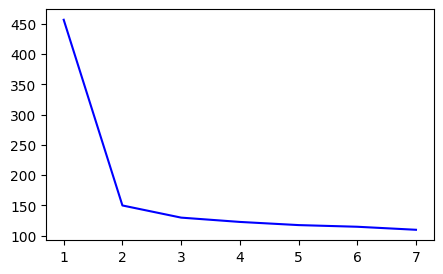

In [88]:
# Applying K-Means and the Elbow Method with scikit-learn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

# After apply PCA to the embeddings data, apply elbow method and KMeans directly since the needs for standardization and outliers removal are lessened by PCA
ssd_word2Vec = []
k_clusters_word2Vec = range(1, 8)
for k in k_clusters_word2Vec:
    kmeans_word2Vec = KMeans(n_clusters=k, max_iter=1000)
    kmeans_word2Vec.fit(np.stack(pca_result_df_word2Vec["features"]))
    ssd_word2Vec.append(kmeans_word2Vec.inertia_)

plt.figure(figsize=(5, 3))
plt.plot(k_clusters_word2Vec, ssd_word2Vec, color='blue')
plt.show()

In [89]:
# Select K = 2 based on the above elbow method chart
optimal_k_word2Vec = 2
kmeans_model_word2Vec = KMeans(n_clusters=optimal_k_word2Vec, max_iter=1000, random_state=42)
# Fit the model
kmeans_model_word2Vec.fit(np.stack(pca_result_df_word2Vec["features"]))

# Assign clusters to embeddings
cluster_labels_word2Vec = kmeans_model_word2Vec.labels_
pca_result_df_word2Vec['cluster'] = cluster_labels_word2Vec
print(pca_result_df_word2Vec.shape)
pca_result_df_word2Vec.head()

(58331, 2)


,features,cluster
0,"[-0.007612896536704775, -0.0023725740074480505...",0
1,"[0.004754419248192884, 0.01730540604823029, 0....",0
2,"[0.010422316204246135, 0.022786324518384846, -...",0
3,"[0.00989781755006347, 0.00788859285788129, 0.0...",0
4,"[0.009277536269642853, -0.001542057700470876, ...",0


Find the representative documents of each cluster

In [90]:
from sklearn.metrics import pairwise_distances_argmin_min

# Identify cluster centroids
centroids_word2Vec = kmeans_model_word2Vec.cluster_centers_
# print(centroids)

# Find the closest documents to each centroid
closest_docs_indices_word2Vec, _ = pairwise_distances_argmin_min(centroids_word2Vec, np.stack(pca_result_df_word2Vec['features']))
print("The two document indices that are closest to the two centroids:", list(closest_docs_indices_word2Vec))

The two document indices that are closest to the two centroids: [48912, 21648]


In [91]:
# Extract representative documents (string: title+abstract)
print("Representative document for cluster 1: doc{}.pdf".format(doc_ids[48912]))
print("Representative document for cluster 2: doc{}.pdf".format(doc_ids[21648]))

representDoc_df_word2Vec = pd.DataFrame({
    "Cluster number": [1, 2],
    "Representative Document": ["Doc27", "Doc12"],
    "Title": [raw_title_dict[27], raw_title_dict[12]],
    "Abstract": [abstract_dict[27], abstract_dict[12]]
})

# Save the following information in a CSV file [cluster_info.csv]: Cluster number (integer), Representative documents (string: title+abstract)
representDoc_df_word2Vec.to_csv("cluster_info_word2Vec.csv")
representDoc_df_word2Vec

Representative document for cluster 1: doc27.pdf
Representative document for cluster 2: doc12.pdf


,Cluster number,Representative Document,Title,Abstract
0,1,Doc27,transmutations involving the di-neutron in con...,It has been recently revealed how a lattice bo...
1,2,Doc12,charged particle emission during electron beam...,Energetic charged particle emissions accompany...


**2. Doc2Vec**

In [ ]:
# TBD

### b. Visualize the clusters created using any visualization

**1. Word2Vec - Visualize**

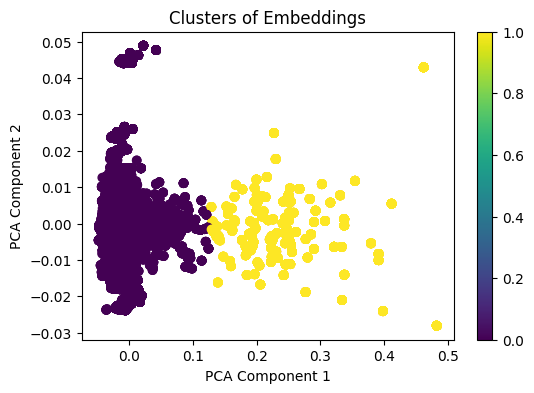

In [92]:
# For a 2D visualization, need to apply PCA again to further reduce the embeddings from 30-dimension to 2-dimension
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
reduced_features_word2Vec = pca_2d.fit_transform(list(pca_result_df_word2Vec['features']))

# Create a scatter plot, using the two PCA components for plotting
plt.figure(figsize=(6, 4))
plt.scatter(reduced_features_word2Vec[:, 0], reduced_features_word2Vec[:, 1], c=pca_result_df_word2Vec['cluster'], cmap='viridis', marker='o')
plt.title('Clusters of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

In [93]:
print(reduced_features_word2Vec)

[[-0.03889165  0.00182018]
 [-0.02652433 -0.01786851]
 [-0.02085644 -0.02340809]
 ...
 [-0.0178152  -0.00365396]
 [-0.01711056 -0.01339513]
 [-0.02251897 -0.00908643]]


**2. Doc2Vec - Visualize**

In [ ]:
# TBD

## 5. Class-based TF-IDF [20 points]
To obtain themes from each cluster, we will apply TF-IDF on the cluster level (and not the document level). Create a class-based TF-IDF matrix. For example, if there are 5 clusters, then you will have 5 entries (rows) in your TF-IDF matrix. (In other words, you are combining the documents in a particular cluster and treating it as one document in the corpus)
Extract the top six keywords from each cluster. Append this information to the cluster_info.csv file. [Cluster number, representative documents, top keywords]

**1. Word2Vec - TF-IDF**

In [94]:
# To perform TF-IDF, first map all the embeddings in pca_result_df back to their original token in clearToken_dict
all_tokens = []
for doc, tokens in cleanToken_dict.items():
    for token in tokens:
        all_tokens.append(token)

# Make sure
print(len(all_tokens))
print(len(all_embeddings_word2Vec))

# Concat the original words to pca_result_df
pca_result_df_word2Vec['Word'] = all_tokens
print(pca_result_df_word2Vec.shape)
pca_result_df_word2Vec.head()

58331
58331
(58331, 3)


,features,cluster,Word
0,"[-0.007612896536704775, -0.0023725740074480505...",0,introduction
1,"[0.004754419248192884, 0.01730540604823029, 0....",0,excess
2,"[0.010422316204246135, 0.022786324518384846, -...",0,power
3,"[0.00989781755006347, 0.00788859285788129, 0.0...",0,effect
4,"[0.009277536269642853, -0.001542057700470876, ...",0,observed


In [95]:
print("Number of words in each cluster")
pca_result_df_word2Vec.groupby("cluster")["Word"].size().reset_index(name="# of words")

Number of words in each cluster


,cluster,# of words
0,0,54473
1,1,3858


In [96]:
# Aggregate words by cluster for TF-IDF
clustered_words = pca_result_df_word2Vec.groupby("cluster")["Word"].apply(lambda x: " ".join(x)).reset_index(name='aggregated_words')
clustered_words

,cluster,aggregated_words
0,0,introduction excess power effect observed usin...
1,1,hydrogen desorption high hydrogen shown excita...


In [97]:
# Compute TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer_word2Vec = TfidfVectorizer(stop_words='english')
tfidf_matrix_word2Vec = vectorizer_word2Vec.fit_transform(clustered_words['aggregated_words'])
print(tfidf_matrix_word2Vec.shape)

# Extract feature names to access the words
feature_names_word2Vec = vectorizer_word2Vec.get_feature_names_out()
feature_names_word2Vec

# Extract top 6 keywords for each cluster
top_n = 6
top_keywords_by_cluster_word2Vec = []  # 2 clusters for word2Vec

for cluster_idx in range(tfidf_matrix_word2Vec.shape[0]):
    # Extract TF-IDF scores for the current cluster and sort them in descending order
    row_data = tfidf_matrix_word2Vec.getrow(cluster_idx)
    # argsort() returns the index of the array sorted by the TF-IDF scores of each word
    sorted_items = row_data.toarray().flatten().argsort()[::-1]  # Sort the TF-IDF scores of each element from high to low
    # Get the top 6 keywords for the cluster
    top_words_idx_word2Vec = sorted_items[:top_n]
    top_words_word2Vec = [feature_names_word2Vec[i] for i in top_words_idx_word2Vec]
    top_keywords_by_cluster_word2Vec.append(top_words_word2Vec)

print("Top 6 keywords for each cluster:")
top_keywords_by_cluster_word2Vec

(2, 6389)
Top 6 keywords for each cluster:


[['heat', 'energy', 'excess', 'cathode', 'power', 'electrolysis'],
 ['pd', 'sample', 'mev', 'pdo', 'track', 'detector']]

In [98]:
# Row 0: Contains "TF-IDF scores" for all 6389 words based on their occurrence and importance in the first cluster's aggregated document. High scores in this row point to words that are distinctive of the first cluster.
# Row 1: Contains TF-IDF scores for the words based on the second cluster's aggregated document. High scores here highlight words that define or distinguish the second cluster.
print(tfidf_matrix_word2Vec.shape)

(2, 6389)


In [99]:
top_words_df = pd.DataFrame({"Top Keywords": [top_keywords_by_cluster_word2Vec[0], top_keywords_by_cluster_word2Vec[1]]})
final_cluster_info = pd.concat([representDoc_df_word2Vec, top_words_df], axis=1)

final_cluster_info.to_csv("cluster_info_word2Vec.csv")
final_cluster_info

,Cluster number,Representative Document,Title,Abstract,Top Keywords
0,1,Doc27,transmutations involving the di-neutron in con...,It has been recently revealed how a lattice bo...,"[heat, energy, excess, cathode, power, electro..."
1,2,Doc12,charged particle emission during electron beam...,Energetic charged particle emissions accompany...,"[pd, sample, mev, pdo, track, detector]"


**2. Doc2Vec - TF-IDF**

In [ ]:
# TBD
# Can use "all_tokens" list directly to map the embeddings created by Doc2Vec